# Identification of DNA-binding motifs case study 

This section will present a comparative analysis to demonstrate the application and performance of proPythia for addressing sequence-based prediction problems.

We'll try to replicate the [Deep Learning in Genomics Primer Notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) which is a supplement to the manuscript [A Primer on Deep Learning in Genomics](https://www.nature.com/articles/s41588-018-0295-5).

The main focus of this notebook is to demonstrate the application of proPythia to the identification of DNA-binding motifs using DNA descriptors.

In [1]:
%load_ext autoreload

import sys
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

sys.path.append('../../../../src/')
from propythia.shallow_ml import ShallowML

from descriptors import DNADescriptor

In [2]:
dataset = pd.read_csv("dataset.csv")
print(dataset.shape)
print(dataset.head())

(2000, 2)
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the presence of a DNA-binding motif. The amount of positive and negative examples is evenly distributed across the two classes.

<AxesSubplot:xlabel='label'>

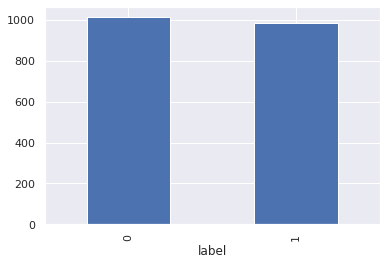

In [3]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

To calculate features, and to be more easy, we create a function to calculate features, calculating all available DNA features.
There are a total of 20 DNA descriptors. They are: 
- length
- gc_content
- at_content
- nucleic_acid_composition
- enhanced_nucleic_acid_composition
- dinucleotide_composition
- trinucleotide_composition
- k_spaced_nucleic_acid_pairs
- kmer
- nucleotide_chemical_property
- accumulated_nucleotide_frequency
- DAC
- DCC
- DACC
- TAC
- TCC
- TACC
- PseDNC
- PseKNC
- binary

In [4]:
# List of descriptors to be calculed. If empty, all descriptors will be calculated.
specifics = []

def calculate_feature(data):
    list_feature = []
    count = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        feature = dna.get_descriptors(specifics=specifics)
        res.update(feature)
        list_feature.append(res)
        
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df

features = calculate_feature(dataset)

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000
Done!


In [5]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
fps_x.shape

(2000, 20)

Now, we have a dataset (fps_x) with 20 columns. Each column is a result of a DNA descriptor, and some of these columns are numbers, dicts and even lists.

Even though we've computed all of the descriptors, we still need to normalize those who have dictionaries and lists because the model can't handle data in these types.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

In [6]:
no_need_normalization = ["length", "at_content", "gc_content"]

need_dict_normalization = ["nucleic_acid_composition", "enhanced_nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC"]

need_list_normalization = ["nucleotide_chemical_property", "accumulated_nucleotide_frequency", "DAC", "DCC", "DACC", "TAC","TCC","TACC", "binary"]

def normalize_dict(d, field):
    df = pd.json_normalize(d)
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    
    for f in df.columns:
        if isinstance(df[f][0], dict):
            df = pd.concat([df, normalize_dict(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
    return df

def normalize_list(l, field):
    df = pd.DataFrame(l.to_list())
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    
    for f in df.columns:
        if isinstance(df[f][0], list):
            df = pd.concat([df, normalize_list(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
    return df

new_fps_x = pd.DataFrame()

for col in fps_x.columns:
    if col in need_dict_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_dict(fps_x[col], col)], axis=1)
    elif col in need_list_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_list(fps_x[col], col)], axis=1)
    else:
        new_fps_x[col] = fps_x[col].to_numpy()
        
new_fps_x

,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,enhanced_nucleic_acid_composition_0_A,enhanced_nucleic_acid_composition_0_C,enhanced_nucleic_acid_composition_0_G,...,binary_47_2,binary_47_3,binary_48_0,binary_48_1,binary_48_2,binary_48_3,binary_49_0,binary_49_1,binary_49_2,binary_49_3
0,50,0.60,0.40,0.18,0.26,0.34,0.22,0.2,0.4,0.4,...,0,0,0,1,0,0,0,1,0,0
1,50,0.48,0.52,0.12,0.16,0.32,0.40,0.2,0.0,0.4,...,0,1,0,1,0,0,0,0,1,0
2,50,0.54,0.46,0.34,0.26,0.28,0.12,0.4,0.2,0.2,...,0,0,0,1,0,0,0,0,0,1
3,50,0.64,0.36,0.24,0.42,0.22,0.12,0.2,0.4,0.2,...,0,0,0,0,0,1,0,0,1,0
4,50,0.54,0.46,0.28,0.26,0.28,0.18,0.2,0.2,0.6,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,0.66,0.34,0.16,0.26,0.40,0.18,0.0,0.4,0.4,...,1,0,1,0,0,0,0,0,1,0
1996,50,0.44,0.56,0.22,0.22,0.22,0.34,0.0,0.2,0.4,...,0,1,0,1,0,0,0,0,0,1
1997,50,0.46,0.54,0.18,0.24,0.22,0.36,0.2,0.4,0.2,...,0,0,0,1,0,0,0,0,0,1
1998,50,0.48,0.52,0.28,0.24,0.24,0.24,0.4,0.2,0.2,...,1,0,1,0,0,0,1,0,0,0


At this point, the data is ready to be used by the model. We will train the model, obtain the predictions and then calculate feature importance. We'll do this process for rf, svm and linear_svm models.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(new_fps_x, fps_y, stratify=fps_y)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=new_fps_x.columns)

param_grid = [{'clf__n_estimators': [100, 250, 500, 750], 'clf__max_features': ['sqrt']}]

best_rf_model = ml.train_best_model(
    model_name=None,
    model='rf',
    score=make_scorer(matthews_corrcoef),
    param_grid=param_grid,
    cv=10
)

performing gridSearch...
GridSearchCV took 11.16 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=10,
             param_grid=[{'clf__max_features': ['sqrt'],
                          'clf__n_estimators': [100, 250, 500, 750]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.987 (std: 0.012)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
 

Model with rank: 1
 Mean validation score: 0.987 (std: 0.012)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 750}
 

Model with rank: 3
 Mean validation score: 0.985 (std: 0.013)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 250}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parame

In [8]:
scores, report, cm, cm2 = ml.score_testset(best_rf_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       253
           1       0.99      1.00      1.00       247

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

[[251   2]
 [  0 247]]


{'Accuracy': 0.996,
 'MCC': 0.9920313645410062,
 'log_loss': 0.09699388530323463,
 'f1 score': 0.995967741935484,
 'roc_auc': 0.9960474308300395,
 'Precision': array([0.99196787, 1.        ]),
 'Recall': array([1., 0.]),
 'fdr': 0.008032128514056224,
 'sn': 1.0,
 'sp': 0.9920948616600791}

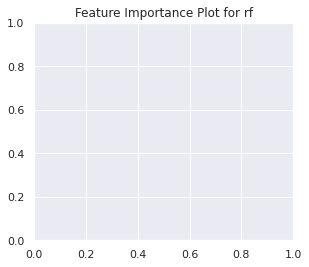

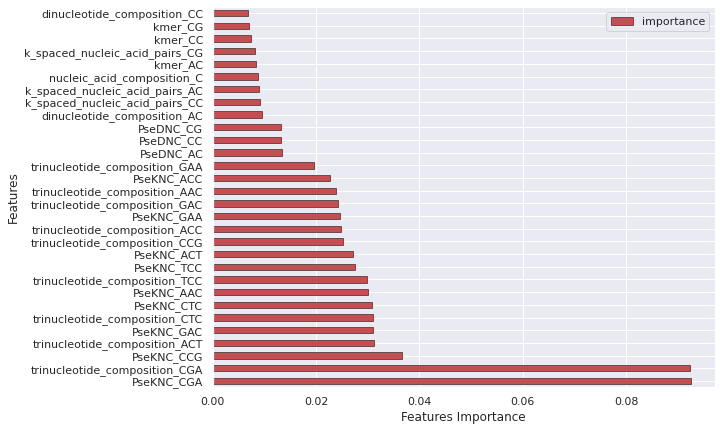

<Figure size 432x288 with 0 Axes>

In [9]:
ml.features_importances_plot(
    classifier=best_rf_model, 
    top_features=30, 
    model_name='rf',
    show=True, 
    path_save=None
)

Let's try now using SVM to predict the binding motifs.

In [10]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=new_fps_x.columns)

param_grid = {'clf__C':[10], 'clf__gamma':[0.001], 'clf__kernel':['rbf']}

best_svm_model = ml.train_best_model(
    model_name=None,
    model='svm',
    score=make_scorer(matthews_corrcoef),
    param_grid=param_grid,
    cv=10
)

performing gridSearch...
GridSearchCV took 1.66 seconds for 1 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=10,
             param_grid={'clf__C': [10], 'clf__gamma': [0.001],
                         'clf__kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.923 (std: 0.030)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.923
 Parameters:	{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

0.923308 (0.030402) with: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
   clf__C  clf__gamma clf__kernel     means      stds
0      10       0.001         rbf  0.923308  0.030402


In [11]:
scores, report, cm, cm2 = ml.score_testset(best_svm_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       253
           1       0.96      0.98      0.97       247

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

[[242  11]
 [  4 243]]


{'Accuracy': 0.97,
 'MCC': 0.940380077490309,
 'f1 score': 0.9700598802395209,
 'roc_auc': 0.9701637035733145,
 'Precision': array([0.494     , 0.95669291, 1.        ]),
 'Recall': array([1.        , 0.98380567, 0.        ]),
 'fdr': 0.04330708661417323,
 'sn': 0.9838056680161943,
 'sp': 0.9565217391304348}

The SVM feature importance can only be calculated if the best model has a linear kernel. Since the best model has the RBF kernel, we can't calculate the feature importance, so we will use the linear_svm model instead.

In [12]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=new_fps_x.columns)

best_linear_svm_model = ml.train_best_model(
    model_name=None,
    model='linear_svm',
    score=make_scorer(matthews_corrcoef),
    param_grid=None,
    cv=10
)

performing gridSearch...


/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jabreu/miniconda3/envs/dna-conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jabreu/minicon

GridSearchCV took 2.00 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', LinearSVC(random_state=1))]),
             n_jobs=10, param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.866 (std: 0.031)
 Parameters: {'clf__C': 0.01}
 

Model with rank: 2
 Mean validation score: 0.833 (std: 0.031)
 Parameters: {'clf__C': 1.0}
 

Model with rank: 2
 Mean validation score: 0.833 (std: 0.031)
 Parameters: {'clf__C': 10}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.866
 Parameters:	{'clf__C': 0.01}

0.865962 (0.031182) with: {'clf__C': 0.01}
0.832473 (0.037776) with: {'clf__C': 0.1}
0.832651 (0.031033) with: {'clf__C': 1.0}
0.832651 (0.031033) with: {'clf__C': 10}
   clf__C     means      

In [13]:
scores, report, cm, cm2 = ml.score_testset(best_linear_svm_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       253
           1       0.96      0.96      0.96       247

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

[[242  11]
 [  9 238]]


{'Accuracy': 0.96,
 'MCC': 0.9200256039326778,
 'f1 score': 0.9596774193548387,
 'roc_auc': 0.960042246083436,
 'Precision': array([0.494     , 0.95582329, 1.        ]),
 'Recall': array([1.        , 0.96356275, 0.        ]),
 'fdr': 0.04417670682730924,
 'sn': 0.9635627530364372,
 'sp': 0.9565217391304348}

In [18]:
# df = ml.features_importances_df(classifier=best_linear_svm_model, model_name='linear_svm', top_features=30, column_to_sort=None)


ml.features_importances_plot(
    classifier=best_linear_svm_model, 
    model_name='linear_svm',
    show=True, 
    path_save=None
)

KeyError: None